# Report

---
# Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from dotenv import load_dotenv
import awswrangler as wr
import os
import yaml
import boto3

In [87]:
# load environment variables with
load_dotenv()

# import config
with open("../config.yaml") as f:
    config = yaml.safe_load(f)

# connect to AWS with credentials
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("REGION")
BUCKET = os.getenv("BUCKET")
FOLDER = config["aws"]["folder"]

# connect to AWS
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION
)
s3 = session.client("s3")

---
# Data

## Users

In [9]:
# get data from S3
gdf_users = (
    wr.s3.read_parquet(
        f"s3://{BUCKET}/{FOLDER}/{config['aws']['users-file']}"
    )
    .rename(columns={"client_latitude": "latitude", "client_longitude": "longitude"})
    # convert to GeoDataFrame
    .pipe(gpd.GeoDataFrame)
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude'], x['latitude'])
    )
    .set_crs(epsg=4326)
)
gdf_users.head()

/Users/ravj/opt/anaconda3/envs/bait-telecom/lib/python3.9/site-packages/awswrangler/_distributed.py:104: FutureWarning: promote has been superseded by promote_options='default'.
  return cls.dispatch_func(func)(*args, **kw)
/Users/ravj/opt/anaconda3/envs/bait-telecom/lib/python3.9/site-packages/pandas/core/frame.py:5226: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data[k] = com.apply_if_callable(v, data)


,device_id,postal_code,raw_sim_operator_name,longitude,latitude,geometry
0,436672830.0,47472,BAIT,-101.961,21.333,POINT (-101.96100 21.33300)
1,464809820.0,27087,Mega4.5G,-103.331,25.539,POINT (-103.33100 25.53900)
2,434158753.0,29454,Sin servicio,-92.275,16.845,POINT (-92.27500 16.84500)
3,409155526.0,57750,BAIT,-99.025,19.387,POINT (-99.02500 19.38700)
4,456104373.0,30190,BAIT,-92.038,16.735,POINT (-92.03800 16.73500)


<Axes: >

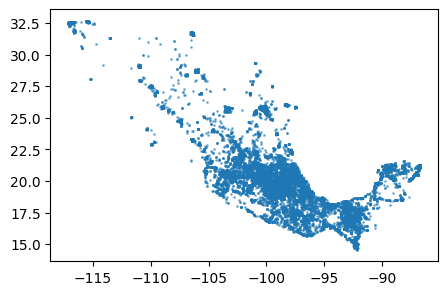

In [15]:
gdf_users.plot(
    figsize=(5, 5),
    alpha=0.5,
    markersize=1
)

## Stores

In [97]:
# get walmart
re_walmart = r"(walmart|wal mart|superama|waltmart)"
re_sams = r"(sams|sam's|sam s|sam's club|sam s club|sam'sclub|sam sclub|sam club|mi bodega)"
re_bodega = r"(bodega aurrera|bodega|aurrera|ba|boa|\$b|mb|b )"
re_supercenter = r"(supercenter|super center)"

gdf_walmart = (
    wr.s3.read_csv(
        f"s3://{BUCKET}/{FOLDER}/{config['aws']['walmart-file']}"
    )
    .pipe(gpd.GeoDataFrame)
    .assign(
        geometry=lambda x: gpd.points_from_xy(x['longitude'], x['latitude']),
        # get bodega aurrera or walmart or sams in name
        store_name=lambda x: np.select(
            [
                x['name'].str.contains(re_bodega, case=False),
                x['name'].str.contains(re_walmart, case=False),
                x['name'].str.contains(re_sams, case=False),
                x['name'].str.contains(re_supercenter, case=False)
            ],
            ['bodega aurrera', 'walmart', 'sams', 'supercenter'],
            default='other'
        )
    )
    .query("store_name != 'other'")
    .loc[:, [
             'id', 'store_name', 'name', 'staff_stratum_description',
             'postal_code', 'cve_ent', 'cve_mun', 'geometry'
            ]]
)
gdf_walmart.head()

/Users/ravj/opt/anaconda3/envs/bait-telecom/lib/python3.9/site-packages/pandas/core/frame.py:5226: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  data[k] = com.apply_if_callable(v, data)
/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_93433/2723010183.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  x['name'].str.contains(re_bodega, case=False),
/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_93433/2723010183.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match gr

,id,store_name,name,staff_stratum_description,postal_code,cve_ent,cve_mun,geometry
0,1263973,bodega aurrera,BODEGA AURRERA PENAFLOR 1253,101 a 250 personas,76116,22,14,POINT (-100.47861 20.64249)
1,1263981,bodega aurrera,BODEGA AURRERA EXPRESS MISION QUERETARO 3404,6 a 10 personas,76116,22,14,POINT (-100.46298 20.64603)
2,1263982,bodega aurrera,BODEGA AURRERA EXPRESS SAN PEDRO 2978,11 a 30 personas,76113,22,14,POINT (-100.46554 20.61523)
3,1263983,bodega aurrera,BODEGA AURRERA,0 a 5 personas,76010,22,14,POINT (-100.42465 20.58914)
4,1263987,bodega aurrera,BODEGA AURRERA BELEN 2554,11 a 30 personas,76148,22,14,POINT (-100.39423 20.64687)


In [77]:
# count stores
gdf_walmart['store_name'].value_counts()

store_name
bodega aurrera    2061
supercenter        251
sams               150
walmart            136
Name: count, dtype: int64

<Axes: >

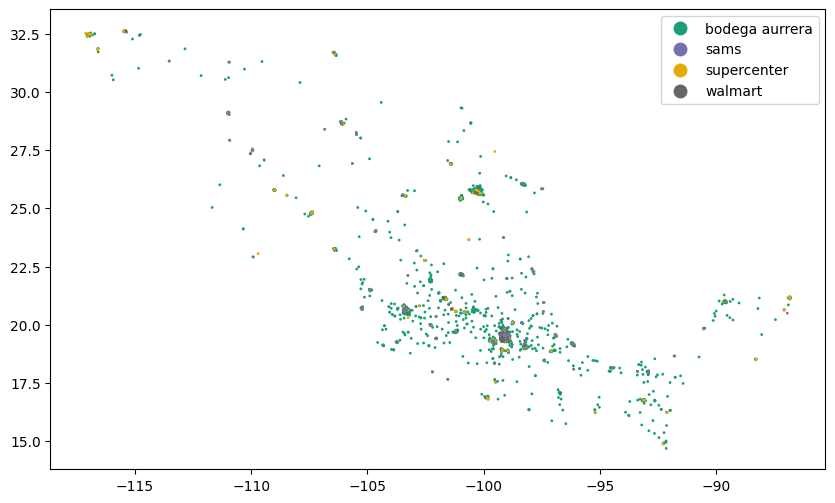

In [85]:
# plot stores by store name
gdf_walmart.plot(
    figsize=(10, 10),
    markersize=1,
    column='store_name',
    legend=True,
    cmap='Dark2'
)

## Inegi States

In [127]:
from shapely import wkb

# download shapefile of states
gdf_states = (
    wr.s3.read_parquet(
        "s3://itam-analytics-javier/telecom-outputs/mexico_states.parquet"
    )
    # pass geometry column from binary to geometry
    .assign(geometry=lambda x: x['geometry'].apply(wkb.loads))
    .pipe(gpd.GeoDataFrame)
    .set_crs(epsg=4326)
)
gdf_states.head()

/Users/ravj/opt/anaconda3/envs/bait-telecom/lib/python3.9/site-packages/awswrangler/_distributed.py:104: FutureWarning:

promote has been superseded by promote_options='default'.



,CODIGO,ESTADO,geometry
0,MX02,Baja California,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,MX03,Baja California Sur,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,MX18,Nayarit,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."
3,MX14,Jalisco,"POLYGON ((-101.52490 21.85664, -101.58830 21.7..."
4,MX01,Aguascalientes,"POLYGON ((-101.84620 22.01176, -101.96530 21.8..."


<Axes: >

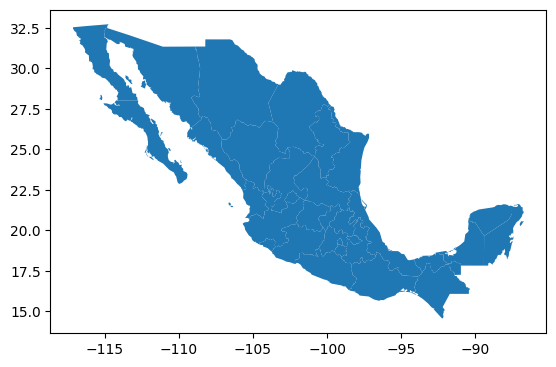

In [128]:
gdf_states.plot()

---
# EDA

In [100]:
import plotly.express as px

In [109]:
# bar plot of device_id by raw_sim_operator_name in plotly
fig = px.bar(
    gdf_users,
    x='raw_sim_operator_name',
    y='device_id',
    title='Device ID by State',
    labels={'device_id': 'Device ID', 'raw_sim_operator_name': 'SIM Operator'},
    color='raw_sim_operator_name',
    color_discrete_sequence=px.colors.qualitative.Safe
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed